### This notebook is used for developing modified fastText model -- fastText2

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding, Activation, GlobalAveragePooling1D
from keras.models import load_model
from keras.callbacks import EarlyStopping

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from nltk.tokenize.casual import TweetTokenizer

Using TensorFlow backend.


## Data Processing

In [2]:
# loading data
empathies = pd.read_csv('./empathies.csv')
msg = pd.read_csv('./msg_fasttext.csv')
msg.shape

(3561, 6)

In [3]:
# drop irrelevant columns
msg = msg.drop(msg.columns[0:2], axis=1)

In [4]:
# use NLTK TweetTokenizer to tokenize data. The TweetTokenizer is able to recognize emoji
sentences_tokens = []
for m in msg['message']:
    tokens = TweetTokenizer().tokenize(m.lower())
    sentences_tokens.append(tokens)

In [5]:
# obain a set of all the tokens
token_set = []
for sen in sentences_tokens:
    for tok in sen:
        if tok not in token_set:
            token_set.append(tok)

In [6]:
len(token_set)

2196

In [12]:
# indexing tokens
token_indices = dict((c, i) for i, c in enumerate(token_set))
indices_token = dict((i, c) for i, c in enumerate(token_set))

In [13]:
# transform original input data into token index
max_len = 128
X = []

for i, sen in enumerate(sentences_tokens):
    sen2token = []
    for j, tok in enumerate(sen):
        if j < max_len:
            sen2token.append(token_indices[tok])
    X.append(sen2token)

In [14]:
# code borrowed from https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py
def create_ngram_set(input_list, ngram_value):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [15]:
# code borrowed from https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py
def add_ngram(sequences, token_indice, ngram_range):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [16]:
ngram_range = 3

In [17]:
# code modified from https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py
max_features = len(token_set)

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in X:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice2 = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token2 = {token_indice2[k]: k for k in token_indice2}
    

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token2.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    X_ft = add_ngram(X, token_indice2, ngram_range)
    print('Average sequence length: {}'.format(np.mean(list(map(len, X_ft)), dtype=int)))

Adding 3-gram features
Average sequence length: 11


In [18]:
# padding input data
X_padding = pad_sequences(X, maxlen = 128)

In [19]:
# get training and testing data
train_padding = X_padding[:2500]
test_padding = X_padding[2500:]

In [20]:
# get ground truth
sentiments = np.zeros((msg.shape[0], empathies.shape[0]), dtype = np.int64)
i = 0
for emps in msg['empathy']:
    for emp in emps.split(','):
        emp = emp.strip()
        try:
            idx = empathies[empathies['empathy'] == emp].index[0]
            sentiments[i][idx] = 1
        except:
            print(emp)
    i += 1

In [21]:
train_y = sentiments[:2500]
test_y = sentiments[2500:]

## Model Setup & Training

In [22]:
# fastText model
# code modified from https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py

EMBEDDING_DIM = 100

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    EMBEDDING_DIM,
                    input_length = 128))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(64, activation='softmax'))

adam = keras.optimizers.Adam(lr=0.05)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          1958500   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
Total params: 1,964,964
Trainable params: 1,964,964
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Early stopping
early_stopping = EarlyStopping(monitor = ['val_loss'], min_delta = 0.01, 
                              patience = 5, verbose = 1, mode = 'auto')

# training
model.fit(train_padding, train_y,
          batch_size = 256,
          epochs = 40,
          shuffle = True,
          validation_data=(test_padding, test_y))

Train on 2500 samples, validate on 1061 samples
Epoch 1/40
2500/2500 [==============================] - 1s - loss: 5.2355 - acc: 0.0292 - val_loss: 5.1750 - val_acc: 0.0377
Epoch 2/40
2500/2500 [==============================] - 0s - loss: 5.0094 - acc: 0.0604 - val_loss: 5.0479 - val_acc: 0.0424
Epoch 3/40
2500/2500 [==============================] - 0s - loss: 4.8626 - acc: 0.0828 - val_loss: 4.8807 - val_acc: 0.1423
Epoch 4/40
2500/2500 [==============================] - 1s - loss: 4.5875 - acc: 0.2020 - val_loss: 4.6183 - val_acc: 0.1960
Epoch 5/40
2500/2500 [==============================] - 0s - loss: 4.1427 - acc: 0.3212 - val_loss: 4.2010 - val_acc: 0.3421
Epoch 6/40
2500/2500 [==============================] - 0s - loss: 3.5405 - acc: 0.5000 - val_loss: 3.6931 - val_acc: 0.4062
Epoch 7/40
2500/2500 [==============================] - 0s - loss: 2.8912 - acc: 0.5868 - val_loss: 3.2299 - val_acc: 0.4760
Epoch 8/40
2500/2500 [==============================] - 1s - loss: 2.3772 - a

In [24]:
# save model
# model.save('fastText2_model_final.h5')
# model = load_model('./fastText2_model_final.h5')

In [25]:
# get predictions
train_preds = model.predict(train_padding)
test_preds = model.predict(test_padding)

## Metrics (relaxed, nonrelaxed & bar-chart)

In [26]:
# get a map that contains empathy and its corresponding polarity score, this map will be used to compute metrics
dict_polarities = {}
for i in range(empathies.shape[0]):
    dict_polarities[empathies.iloc[i][0]] = float(empathies.iloc[i][1])

The following function is used to compare against the ground truth in a **relaxed**  format, which means if the predicted class is not exactly the same as the truth, but has the same polarity score. The prediction will still be counted as truth positive

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [27]:
def compare_truth_relaxed(cutoff_value, dict_polarities, model, inputs, all_preds, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
    
    j = -1
    for i in range(start, stop):
        j += 1
        preds = all_preds[j]
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['empathy'].split(',') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        preds = [list(empathies['empathy'][np.argsort(preds)[63:58:-1]]), np.sort(preds)[63:58:-1]]
        
        for lab, p in zip(preds[0], preds[1]):
            if p > cutoff_value:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                if lab in msg.iloc[i]['empathy'] or dict_polarities[lab] in true_scores:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['empathy'] and dict_polarities[lab] not in true_scores:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['empathy'].split(','):
            true_lab = true_lab.strip()
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs and dict_polarities[lab] not in scores:
                # false negative
                res[true_lab][2] += 1
                
    return res

Similiar as the above function. The following function is used to compare against the ground truth, but in a **nonrelaxed** format -- the predicted class has to be exactly the same as the truth in order to be counted as true positive.

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [38]:
def compare_truth_nonrelaxed(cutoff_value, dict_polarities, model, inputs, all_preds, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
    
    j = -1
    for i in range(start, stop):
        j += 1
        preds = all_preds[j]
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['empathy'].split(',') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        preds = [list(empathies['empathy'][np.argsort(preds)[63:58:-1]]), np.sort(preds)[63:58:-1]]
        
        for lab, p in zip(preds[0], preds[1]):
            if p > cutoff_value:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                if lab in msg.iloc[i]['empathy']:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['empathy']:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['empathy'].split(','):
            true_lab = true_lab.strip()
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs:
                # false negative
                res[true_lab][2] += 1
                
    return res

In [28]:
def overall_score(res):
    '''
    output precision, recall and F1 score
    '''
    num_TP, num_FP, num_FN = 0, 0, 0
    
    for _, vals in res.items():
        num_TP += vals[0]
        num_FP += vals[1]
        num_FN += vals[2]
            
    precision = num_TP/(num_TP+num_FP)
    recall = num_TP/(num_TP+num_FN)
    
    return precision, recall, 2/(1/precision + 1/recall)

In [29]:
# explore the best cutoff value with the training data
ps, rs, fs = [], [], []
for proposed_cut in np.arange(.0, .5, .01):
    res = compare_truth_relaxed(proposed_cut, dict_polarities, model, msg, train_preds, 0, 2500)
    p, r, f = overall_score(res)
    ps.append(p)
    rs.append(rs)
    fs.append(f)

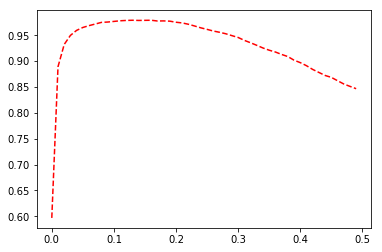

In [30]:
# plot the change of F1 score as the cutoff value increases from 0.0 to 0.5
proposed_cuts = np.arange(.0, .5, .01)
plt.plot(proposed_cuts, fs, 'r--')
plt.show()

In [31]:
# find the best cutoff value
max_fs_idx = fs.index(max(fs))
np.arange(.0, .5, .01)[max_fs_idx]

0.16

In [35]:
# generate bar-chart of true positives, false positives and false negatives for each class
def confu_plot(con_matrix):
    '''
    generate bar-chart of true positives, false positives and false negatives for each class
    '''
    names = []
    TP, FP, FN = [], [], []
    for k, vals in con_matrix.items():
        name=k.replace('__label__', '')
        names.append(name)
        TP.append(vals[0])
        FP.append(vals[1])
        FN.append(vals[2])

    trace1 = go.Bar(
        x=names,
        y=TP,
        name='True Positive'
    )

    trace2 = go.Bar(
        x=names,
        y=FP,
        name='False Positive'
    )

    trace3 = go.Bar(
        x=names,
        y=FN,
        name='False Negative'
    )

    data = [trace1, trace2, trace3]
    layout = go.Layout(
        barmode='group',

        xaxis=dict(
            title='labels',
            titlefont=dict(
                size=18,
            ),
            showticklabels=True,
            tickangle=45,
            tickfont=dict(
                size=14,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='grouped-bar') 

In [33]:
# calculate overall precision, recall and F1 score of validation data with the cutoff value found from above
res = compare_truth_relaxed(.16, dict_polarities, model, msg, test_preds, 2500, msg.shape[0])
overall_scores = overall_score(res)

print('model performance on the validation dataset is: ')
print('precision: {}'.format(overall_scores[0]))
print('recall: {}'.format(overall_scores[1]))
print('F1: {}'.format(overall_scores[2]))

model performance on the validation dataset is: 
precision: 0.8164652567975831
recall: 0.7672107877927609
F1: 0.7910720819612148


In [36]:
# plotting
confu_plot(res)

In [39]:
# explore the best cutoff value with the training data using the non-relaxed comparison function
ps, rs, fs = [], [], []
for proposed_cut in np.arange(.0, .5, .01):
    res = compare_truth_nonrelaxed(proposed_cut, dict_polarities, model, msg, train_preds, 0, 2500)
    p, r, f = overall_score(res)
    ps.append(p)
    rs.append(rs)
    fs.append(f)

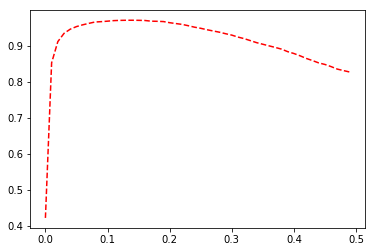

In [40]:
# plot the change of F1 score as the cutoff value increases from 0.0 to 0.5
proposed_cuts = np.arange(.0, .5, .01)
# red dashes
plt.plot(proposed_cuts, fs, 'r--')
plt.show()

In [41]:
# find the best cutoff value
max_fs_idx = fs.index(max(fs))
np.arange(.0, .5, .01)[max_fs_idx]

0.14000000000000001

In [42]:
# calculate overall precision, recall and F1 score of validation data with the cutoff value found from above
res = compare_truth_nonrelaxed(.14, dict_polarities, model, msg, test_preds, 2500, msg.shape[0])
overall_scores = overall_score(res)

print('model performance using non-relaxed comparison function on the validation dataset is: ')
print('precision: {}'.format(overall_scores[0]))
print('recall: {}'.format(overall_scores[1]))
print('F1: {}'.format(overall_scores[2]))

model performance using non-relaxed comparison function on the validation dataset is: 
precision: 0.7674247982391783
recall: 0.7263888888888889
F1: 0.7463432037103104


In [43]:
# plotting
confu_plot(res)

In [44]:
# used for transform a string into the acceptable format for the model
def text_processor(input_str, token_indices, max_len = 128):
    '''
    ---
    args:
        input_str: an input string
        token_indices: map of token index calculated from above
        max_len: the length of input that the model accepts
    ---
    return:
       padded sequence for the model 
    '''
    tokens = TweetTokenizer().tokenize(input_str.lower())
    sen2input = []
    
    for i, token in enumerate(tokens):
        if i < max_len:
            sen2input.append(token_indices[token])
            
    sen2input = add_ngram([sen2input], token_indice2, 3)
    
    return pad_sequences(sen2input, max_len)

### test model performance on emoji 

In [46]:
random_input = text_processor('😋', token_indices)
random_res = model.predict(random_input)
# print out top five predictions
list(empathies['empathy'][np.argsort(random_res[0])[63:58:-1]])

['hungry', 'okay', 'sad', 'tired', 'happy']